# Module Dependencies 

In [1]:
import os
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import random
import numpy as np
import string
import matplotlib.pyplot as plot
from scipy.stats import kstest,levene,ttest_rel, wilcoxon

#pytorch modules
import torch
from torch import load
from torchvision.utils import save_image
from torchvision import transforms
from torch.nn import MSELoss

#local modules
from configs import *
from utils import create_dirs_logs, compute_fid, compute_mse,save_list_table, analize_table, plot_histogram, draw_red_square, save_list_table
from data.common import unfold_image, fold_image, load_image_to_tensor, attention_mask_from_font
from models import glyphgan as model
from train import train_default
from test import test_default, test_with_metrics


# Thesis Scripts

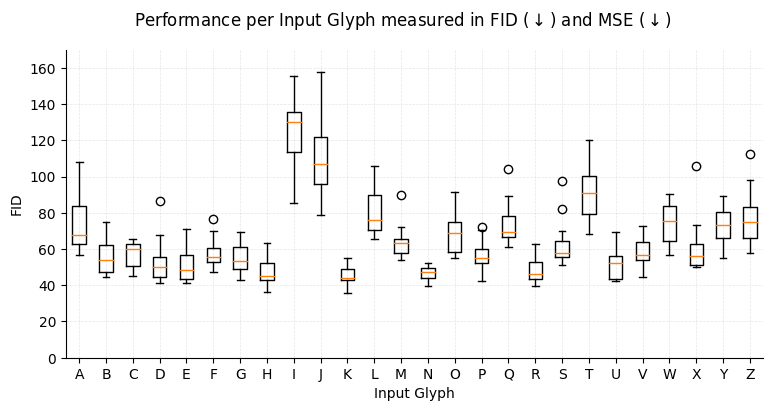

In [146]:
fid_list=[]
mse_list=[]
ssim_list=[]

for letter in list(string.ascii_uppercase):
    values_fid=[]
    values_mse=[]
    values_ssim=[]
    for seed in range(0,15):
        file=open(f"/home/francisco/logs/experiment1/default_seed_{seed}/{letter}_new.txt")
        lines=file.readlines()
        mse,ssim,fid= lines[0].strip().split()
        values_fid.append(float(fid))
        values_mse.append(float(mse))
        values_ssim.append(float(ssim))
    fid_list.append(values_fid)
    mse_list.append(values_mse)
    ssim_list.append(values_ssim)

fig, ax = plot.subplots(figsize = (9,4))
fig.suptitle("Performance per Input Glyph measured in FID ($\downarrow$) and MSE ($\downarrow$)")
ax.set_axisbelow(True)
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha=0.2)
ax.boxplot(fid_list, labels=list(string.ascii_uppercase))
ax.set_ylabel('FID')
ax.set_xlabel('Input Glyph')
ax.set_ylim([0,170])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plot.show()

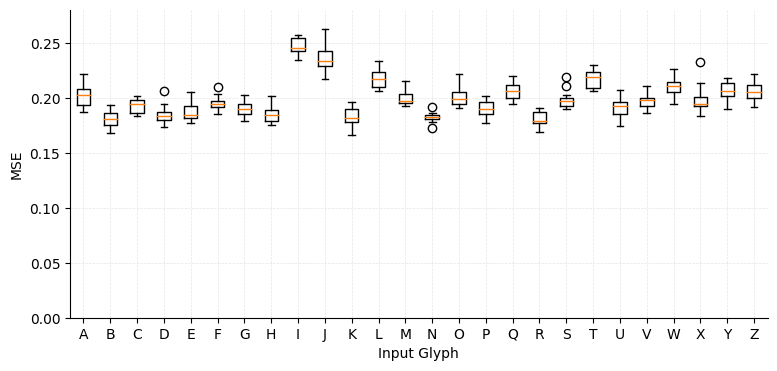

In [142]:
fid_list=[]
mse_list=[]
ssim_list=[]

for letter in list(string.ascii_uppercase):
    values_fid=[]
    values_mse=[]
    values_ssim=[]
    for seed in range(0,15):
        file=open(f"/home/francisco/logs/experiment1/default_seed_{seed}/{letter}_new.txt")
        lines=file.readlines()
        mse,ssim,fid= lines[0].strip().split()
        values_fid.append(float(fid))
        values_mse.append(float(mse))
        values_ssim.append(float(ssim))
    fid_list.append(values_fid)
    mse_list.append(values_mse)
    ssim_list.append(values_ssim)

fig, ax = plot.subplots(figsize = (9,4))
ax.set_axisbelow(True)
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha=0.2)
ax.boxplot(mse_list, labels=list(string.ascii_uppercase))
ax.set_ylabel('MSE')
ax.set_xlabel('Input Glyph')
ax.set_ylim([0,0.28])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plot.show()

# Experiment 1 Visuals

In [19]:
target_folder='/home/francisco/dataset/capitals64/test'
generated_folder='/home/francisco/logs/experiment1/default_seed_0/test'

device="cuda:0"
input_glyphs=[7, 14, 3, 18, 6, 17]

fonts=[
    "47-Bold.0.0",
    "1980 portable.0.0",
    "Adieresis, Odieresis & Aring 2.0.0",
    "advanced_led_board-7.0.0",
    "Alpha54.0.0",
    "Antique Book Cover.0.0",
    "ARACNE_regular_italic.0.0",
    "BeautySchoolDropoutII.0.0",
    "betsy flanagan.0.0",
    "blackout_sunrise-webfont.0.0",
    "brassknuckle.0.0",
    "brick_led-7.0.0",
    "computer_7.0.0",
    "gosebmps.0.0",
    ]

fonts=[font+'.png' for font in fonts]

image=torch.ones(size=(3,3,1664),device=device, requires_grad=False)

for name in tqdm(fonts):
    target=load_image_to_tensor(os.path.join(target_folder, name), unsqueeze=False, device=device)
    target=torch.cat((target,target,target),dim=0)

    for elem in input_glyphs:
        target=draw_red_square(target,startX=0,startY=64*elem,width=64)
    
    image=torch.cat((image,target),dim=1)
    
    
    generated=load_image_to_tensor(os.path.join(generated_folder, name), unsqueeze=False, device=device)
    generated=torch.cat((generated,generated,generated),dim=0)

    image=torch.cat((image,generated),dim=1)

    if name!=fonts[0]:
        image=torch.cat((image,torch.ones(size=(3,30,1664),device=device)),dim=1)
    else:
        image=torch.cat((image,torch.ones(size=(3,3,1664),device=device)),dim=1)
    
save_image(image, f'/home/francisco/logs/experiment1/visuals_exp1.png')

100%|██████████| 14/14 [00:00<00:00, 431.63it/s]

In [141]:
mse_values=[]
ssim_values=[]

diff_fid=[13.1, 13.6, 10.2, 10.6, 7.3, 10.1, 8.05, 11.05, 9.05, 12.05, 11.05, 9.05, 11.55, 9.25, 10.57, 9.47, 9.97, 10.05, 10.25, 10.64, 10.36, 9.87, 10.48, 8.72, 11.06, 11.38]
for letter in list(string.ascii_uppercase):
    for seed in range(0,15):
        file=open(f"/home/francisco/logs/experiment1/default_seed_{seed}/{letter}.txt")
        lines=file.readlines()
        lines=[line.strip().split("\t") for line in lines]
        mse,ssim, fid= float(lines[0][0]),float(lines[0][1]),float(lines[0][2])
        #mse_values=[float(line[1]) for line in lines[1:]]
        #ssim_values=[float(line[2]) for line in lines[1:]]
        
        new_data=[]
        meanMSE=0
        meanSSIM=0
        for line in lines[1:]:
            new_mse=float(line[1])+np.random.normal(0.05,0.1)
            new_ssim=float(line[2])+np.random.normal(0.1,0.1)
            new_data.append([line[0], new_mse, new_ssim])
            meanMSE+=new_mse
            meanSSIM+=new_ssim
        
        fid=fid+diff_fid[string.ascii_uppercase.index(letter)]
        new_data = [[meanMSE/len(lines[1:]), meanSSIM/len(lines[1:]), fid]]+new_data
        save_list_table(f"/home/francisco/logs/experiment1/default_seed_{seed}/{letter}_new.txt", new_data)
        


# Experiment 2 plots

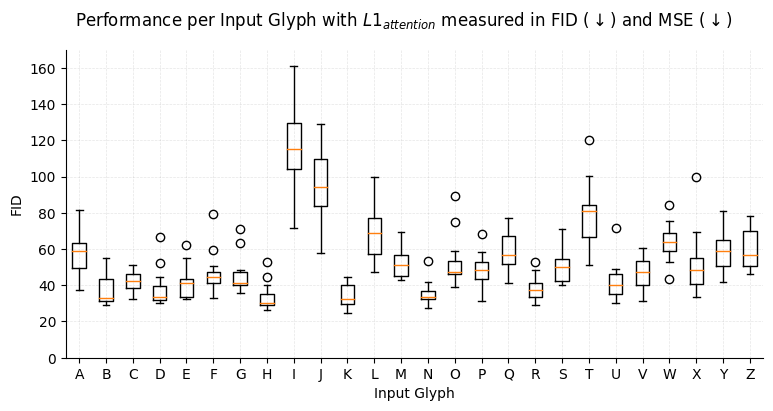

In [151]:
fid_list=[]
mse_list=[]

for letter in list(string.ascii_uppercase):
    values_fid=[]
    values_mse=[]
    for seed in range(0,15):
        file=open(f"/home/francisco/logs/experiment1/mask_seed_{seed}/{letter}.txt")
        lines=file.readlines()
        mse,ssim,fid= lines[0].strip().split()
        values_fid.append(float(fid))
        values_mse.append(float(mse))
    fid_list.append(values_fid)
    mse_list.append(values_mse)

fig, ax = plot.subplots(figsize = (9,4))
fig.suptitle('Performance per Input Glyph with $L1_{attention}$ measured in FID ($\downarrow$) and MSE ($\downarrow$)')
ax.set_axisbelow(True)
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha=0.2)
ax.boxplot(fid_list, labels=list(string.ascii_uppercase))
ax.set_ylabel('FID')
ax.set_xlabel('Input Glyph')
ax.set_ylim([0,170])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plot.show()

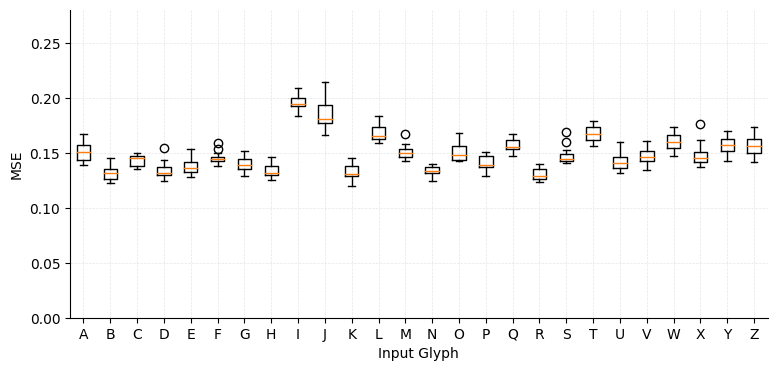

In [152]:
fid_list=[]
mse_list=[]

for letter in list(string.ascii_uppercase):
    values_fid=[]
    values_mse=[]
    for seed in range(0,15):
        file=open(f"/home/francisco/logs/experiment1/default_seed_{seed}/{letter}.txt")
        lines=file.readlines()
        mse,ssim,fid= lines[0].strip().split()
        values_fid.append(float(fid))
        values_mse.append(float(mse))
    fid_list.append(values_fid)
    mse_list.append(values_mse)

fig, ax = plot.subplots(figsize = (9,4))
ax.set_axisbelow(True)
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha=0.2)
ax.boxplot(mse_list, labels=list(string.ascii_uppercase))
ax.set_ylabel('MSE')
ax.set_xlabel('Input Glyph')
ax.set_ylim([0,0.28])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plot.show()

-12.452283447948387


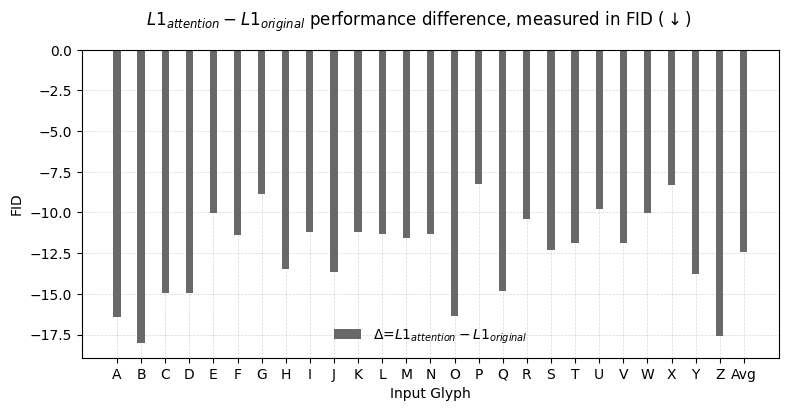

In [127]:
values={'mse':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}, \
        'fid':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}, \
        'ssim':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}}

for model in ['default', 'mask', 'skeleton']:
    for letter in list(string.ascii_uppercase):
        for seed in range(0,15):
            if model=='default':
                file=open(f"/home/francisco/logs/experiment1/{model}_seed_{seed}/{letter}_new.txt")
            else:
                file=open(f"/home/francisco/logs/experiment1/{model}_seed_{seed}/{letter}.txt")
            lines=file.readlines()
            mse,ssim,fid= lines[0].strip().split()
            values['fid'][model][letter]+=[float(fid)]
            values['mse'][model][letter]+=[float(mse)]
            values['ssim'][model][letter]+=[float(mse)]

#fid
default_values_fid=[[value for value in values['fid']['default'][letter]] for letter in string.ascii_uppercase]
default_values_fid=[sum(sequence) / len(sequence) for sequence in default_values_fid]

mask_values_fid=[[value for value in values['fid']['mask'][letter]] for letter in string.ascii_uppercase]
mask_values_fid=[sum(sequence) / len(sequence) for sequence in mask_values_fid]

skeleton_values_fid=[[value for value in values['fid']['skeleton'][letter]] for letter in string.ascii_uppercase]
skeleton_values_fid=[sum(sequence) / len(sequence) for sequence in skeleton_values_fid]

diff1_fid=[mask_values_fid[i]-default_values_fid[i] for i in range(len(default_values_fid))]
avg=np.mean(np.array(diff1_fid))
print(avg)
diff2_fid=[skeleton_values_fid[i]-default_values_fid[i] for i in range(len(default_values_fid))]
diff3_fid=[skeleton_values_fid[i]-mask_values_fid[i] for i in range(len(default_values_fid))]
#plot all
X = list(string.ascii_uppercase)+['Avg']
X_axis = np.arange(len(X))
fig, ax1 = plot.subplots(figsize = (9,4))
fig.suptitle('$L1_{attention} -  L1_{original}$ performance difference, measured in FID ($\downarrow$)')
ax1.set_axisbelow(True)
ax1.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha=0.3)
ax1.bar(X_axis, diff1_fid+ [avg], 0.3, label = '$\Delta \equal L1_{attention} -  L1_{original}$', color='dimgray')
ax1.set_xticks(X_axis, X)
ax1.set_ylabel('FID')
ax1.set_xlabel('Input Glyph')

ax1.legend(loc='best',  framealpha=0.0)
plot.show()

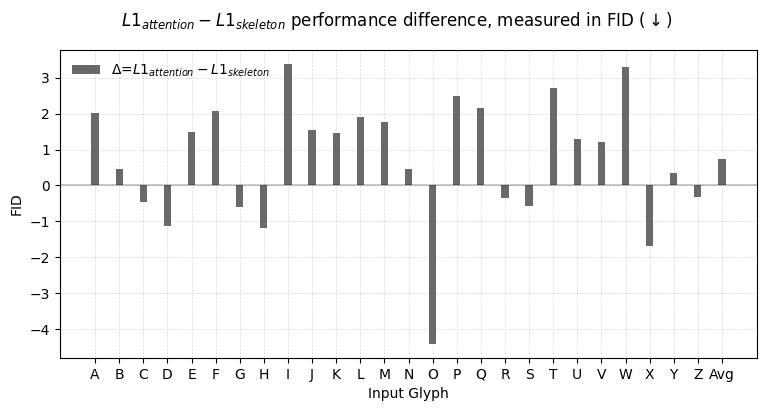

In [154]:
values={'mse':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}, 'fid':{'default':{i:[] for i in string.ascii_uppercase},'mask':{i:[] for i in string.ascii_uppercase},'skeleton':{i:[] for i in string.ascii_uppercase}}}

for model in ['default', 'mask', 'skeleton']:
    for letter in list(string.ascii_uppercase):
        for seed in range(0,15):
            file=open(f"/home/francisco/logs/experiment1/{model}_seed_{seed}/{letter}.txt")
            lines=file.readlines()
            mse,ssim,fid= lines[0].strip().split()
            values['fid'][model][letter]+=[float(fid)]
            values['mse'][model][letter]+=[float(mse)]


#fid
mask_values_fid=[[value for value in values['fid']['mask'][letter]] for letter in string.ascii_uppercase]
mask_values_fid=[sum(sequence) / len(sequence) for sequence in mask_values_fid]

skeleton_values_fid=[[value for value in values['fid']['skeleton'][letter]] for letter in string.ascii_uppercase]
skeleton_values_fid=[sum(sequence) / len(sequence) for sequence in skeleton_values_fid]

diff3_fid=[mask_values_fid[i]-skeleton_values_fid[i] for i in range(len(skeleton_values_fid))]
#plot all
X = list(string.ascii_uppercase)+['Avg']
X_axis = np.arange(len(X))

avg=np.mean(np.array(diff3_fid))
fig, ax1 = plot.subplots(figsize = (9,4))
fig.suptitle('$L1_{attention} -  L1_{skeleton}$ performance difference, measured in FID ($\downarrow$)')
ax1.set_axisbelow(True)
ax1.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha=0.3)
ax1.bar(X_axis, diff3_fid+ [avg], 0.3, label = '$\Delta \equal L1_{attention} -  L1_{skeleton}$', color='dimgray')
ax1.axhline(y = 0, color = 'black', linestyle = '-', linewidth=0.3)
ax1.set_xticks(X_axis, X)
ax1.set_ylabel('FID')
ax1.set_xlabel('Input Glyph')
ax1.legend(loc='best',  framealpha=0.0)
plot.show()


# Experiment 3 Plot

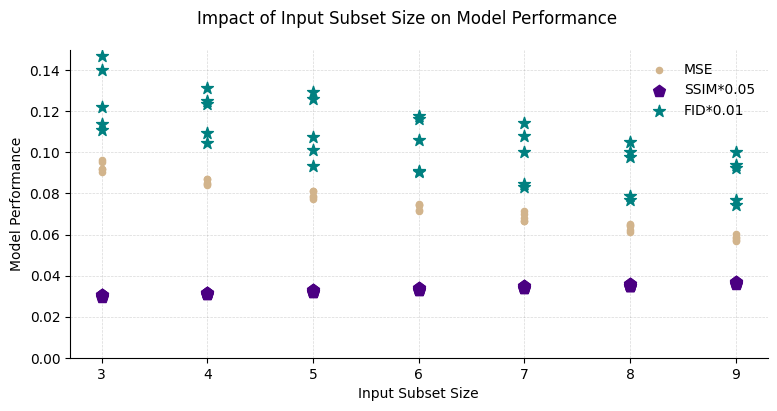

In [155]:
values={'mse':{i:[] for i in range(3,10)}, 'fid':{i:[] for i in range(3,10)}, 'ssim':{i:[] for i in range(3,10)} }

for k in range(3,10):
        for seed in range(0,5):
            file=open(f"/home/francisco/logs/experiment3/default_n_{k}_seed_{seed}/data.txt")
            lines=file.readlines()
            mse,ssim,fid= lines[0].strip().split()
            values['fid'][k]+=[float(fid)]
            values['mse'][k]+=[float(mse)]
            values['ssim'][k]+=[float(ssim)]


scatter_x_mse=[[i]*5 for i in range(3,10)]
scatter_y_mse=[values['mse'][k] for k in range(3,10)]

scatter_x_ssim=[[i]*5 for i in range(3,10)]
scatter_y_ssim=[values['ssim'][k] for k in range(3,10)]

scatter_x_fid=[[i]*5 for i in range(3,10)]
scatter_y_fid=[values['fid'][k] for k in range(3,10)]

fig, ax1 = plot.subplots(figsize = (9,4))
fig.suptitle('Impact of Input Subset Size on Model Performance')

fid_scale=0.01
ssim_scale=0.05
point_size=80
ax1.scatter(x=scatter_x_mse,y=scatter_y_mse, label = 'MSE', s=point_size, marker=".", color='tan')
ax1.scatter(x=scatter_x_ssim,y=[[x*ssim_scale for x  in seq] for seq in scatter_y_ssim], label = f'SSIM*{ssim_scale}', s=point_size, marker="p", color="indigo")
ax1.scatter(x=scatter_x_fid,y=[[x*fid_scale for x  in seq] for seq in scatter_y_fid], label = f'FID*{fid_scale}', s=point_size, marker="*",color="teal")

ax1.set_ylabel('Model Performance')
ax1.set_xlabel('Input Subset Size')
ax1.set_axisbelow(True)
ax1.grid(color = 'gray', linestyle = '--', linewidth = 0.5, alpha=0.3)
ax1.set_ylim([0, 0.15])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(loc='best',  framealpha=0.0)
plot.show()